In [2]:
import pco
import lsmfx
import numpy as np
from PIL import Image
import scipy
import json
import cv2 as cv

#%matplotlib notebook
import matplotlib.pyplot as plt

In [3]:
# CAMERA PARAMETERS
um_per_px = 0.376  # microns (0.43 for water, 0.376 for ECi)

camera_dict = {
    'number': 0,  # int e.g. 0
    'Y': 2044,  # frame size in pixels - 2044 max Y
    'X': 2048,
    'sampling': um_per_px,
    'shutterMode': 'top middle bottom middle',  ### NOT ACTUALLY USED
    'triggerMode': 'external exposure start & software trigger', # previously 'auto sequence'
    #'triggerMode': 'auto sequence', # previously 'auto sequence'
    'acquireMode': 'auto', # previously 'external'
    'compressionMode': 1,
    'B3Denv': '',  # name of required conda env when B3D is active.
                    # e.g. 'image'. Leave as empty string to allow any env.
    'expTime': 10.0, # in ms, minimum is 0.1ms (100,000ns)
    'slitSize': 20, #not used here!!
    'quantSigma': {'405': 1.0,
                   '488': 1.0,
                   '561': 1.0,
                   '638': 1.0}
}

camera = lsmfx.camera(camera_dict)


In [4]:
pco_cam = pco.Camera(camera_number=camera.number)

pco_cam.configuration = {'exposure time': 10*1.0e-3, # converting ms (camera.expTime) to sec (pco_cam.configuration{'exposure time})
                        'roi': (1,
                                1023-round(camera.Y/2),
                                2060,
                                1026+round(camera.Y/2)),
                        'trigger': camera.triggerMode,
                        'acquire': camera.acquireMode,
                        'pixel rate': 272250000}         # 95333333 (slow scan) or 272250000 (fast scan) - default is slow scan.
                                                        # Documentation says you should use slow scan for lightsheet mode, not sure why (doesn't seem to make a difference)

In [5]:
# commands to set light-sheet mode

freq = 10    #Hz slow scan, max is ~4Hz. Fast scan, max is 10Hz
#line_time = (0.35*1/freq)/camera.Y   #sec
line_time = 20e-6

# parameter='on': turns on light-sheet mode
# line_time=20e-6: sets time before going to next line in sec.
#   Min values: 17 µs @ 286 MHz (fast scan), 40 µs @ 95.3 MHz (slow scan), Max value: 100ms
pco_cam.sdk.set_cmos_line_timing(parameter='on', line_time=line_time)

# lines_exposure=10: number of lines to expose at once
# lines_delay=0: default is zero, not clear what this does yet
pco_cam.sdk.set_cmos_line_exposure_delay(lines_exposure=50,lines_delay=0)

# interface='edge': reverses readout direction. Seems like setting to 'edge' is a requirement
# format='top bottom': tells camera to read whole frame top to bottom (as opposed to simultaneously reading two ROIs)
pco_cam.sdk.set_interface_output_format(interface='edge',format='top bottom')

# Note on set_interface_output_format from SDK manual:
# For all cameras with Camera Link interface it is recommended to use PCO_SetTransferParameter function instead of this 
# function, because the driver layer must be informed about any changes in readout format to successfully rearrange the 
# image data.


cmos_line_timing, line time: set the line time. Min values: 17 µs @ 286 MHz (fast scan), 40 µs @ 95.3 MHz (slow scan)
cmos_line_exposure_delay, lines exposure: # of lines for exposure
cmos_line_exposure_delay, lines delay: # of lines for delay

In [6]:
print(pco_cam.sdk.get_cmos_line_exposure_delay())
print(pco_cam.sdk.get_cmos_line_timing())
print(pco_cam.sdk.get_interface_output_format(interface='edge'))

{'lines exposure': 50, 'lines delay': 0}
{'parameter': 'on', 'line time': 2e-05}
{'format': 0}


In [7]:
import _thread

def input_thread(a_list):
    input()             # use input() in Python3
    a_list.append(True)
    
def do_stuff():
    a_list = []
    _thread.start_new_thread(input_thread, (a_list,))
    while not a_list:
        stuff()

In [8]:
nFrames = 25

win_min = 0
win_max = 1000


# fig, ax = plt.subplots()

pco_cam.record(number_of_images=nFrames, mode='ring buffer')
pco_cam.start()

num_acquired = 0
while num_acquired < 1000:
    pco_cam.wait_for_next_image(num_acquired)
    image = pco_cam.image(0)[0][
                                2:camera.Y + 2,
                                1024 - int(camera.X / 2):1024
                                 - int(camera.X / 2) + camera.X]
    print('You\'ve got an image!', num_acquired + 1, end='\r')
    #     ax.imshow(image,'gray',interpolation='nearest',vmin=win_min,vmax=win_max)
    #     fig.show()
    image_norm = cv.normalize(image,None,0,2**16,cv.NORM_MINMAX)
    cv.imshow("potato", image_norm)
    cv.waitKey(1)
    num_acquired += 1
cv2.destroyAllWindows()

KeyboardInterrupt: 

In [39]:
cv.normalize(im_test,None,0,65000,cv.NORM_MINMAX)

array([[    0],
       [32500],
       [65000]], dtype=int32)

In [22]:
image

array([[ 90,  76,  91, ...,  90, 107,  85],
       [ 97,  88,  92, ...,  93,  96,  92],
       [ 93,  92,  95, ...,  93,  94,  95],
       ...,
       [ 82,  93,  82, ...,  83,  84,  93],
       [ 84,  95,  95, ...,  69,  80,  94],
       [ 83,  86,  87, ...,  89,  90,  89]], dtype=uint16)

win_min = 0
win_max = 1000
plt.imshow(image,'gray',interpolation='nearest',vmin=win_min,vmax=win_max)
plt.show()

**From here down is the previously working version**

In [6]:
nFrames = 25
pco_cam.record(number_of_images=nFrames, mode='sequence non blocking')

In [7]:
try:
    images
except NameError:
    images = np.zeros((camera.Y, camera.X, nFrames))


In [8]:
#del images
#images = np.load('H:/Kevin/OxData.npy')

In [61]:
prev = np.copy(images)

pco_cam.start()

num_acquired = 0
print('Waiting for image...', end='\r')
while num_acquired < nFrames:
    pco_cam.wait_for_next_image(num_acquired)
    print('You\'ve got an image!', num_acquired + 1, 'of', nFrames, 'total', end='\r')
    images[:,:,num_acquired] = pco_cam.image(num_acquired)[0][
                                2:camera.Y + 2,
                                1024 - int(camera.X / 2):1024
                                 - int(camera.X / 2) + camera.X]

    num_acquired += 1

pco_cam.stop() 



In [62]:
index = 10
win_min = 100
win_max = 2000

In [63]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (20,20))

#plt.figure(figsize = (10,10))
#plt.imshow(images[:,:,index],'gray',interpolation='nearest')

ax1.imshow(np.abs(images[:,:,index]),'gray',interpolation='nearest',vmin=win_min,vmax=win_max)
ax1.title.set_text('Current')
#plt.title('Frame number: ' + str(index+1))
#plt.show()


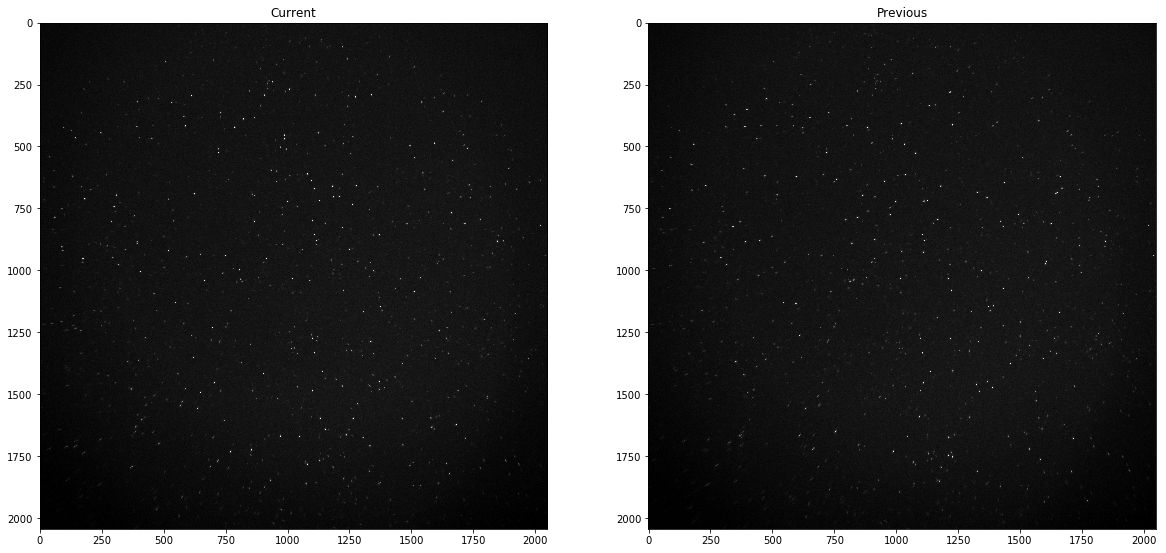

In [64]:
#fig, ax2 = plt.subplots(figsize = (7,7))
ax2.imshow(prev[:,:,index],'gray',interpolation='nearest',vmin=win_min,vmax=win_max)
ax2.title.set_text('Previous')
plt.show()


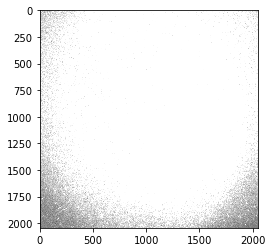

In [60]:
fig, ax = plt.subplots()

#plt.figure(figsize = (10,10))
#plt.imshow(images[:,:,index],'gray',interpolation='nearest')

ax.imshow(images[:,:,index],'gray',interpolation='nearest',vmin=0,vmax=200)
plt.show()


<IPython.core.display.Javascript object>


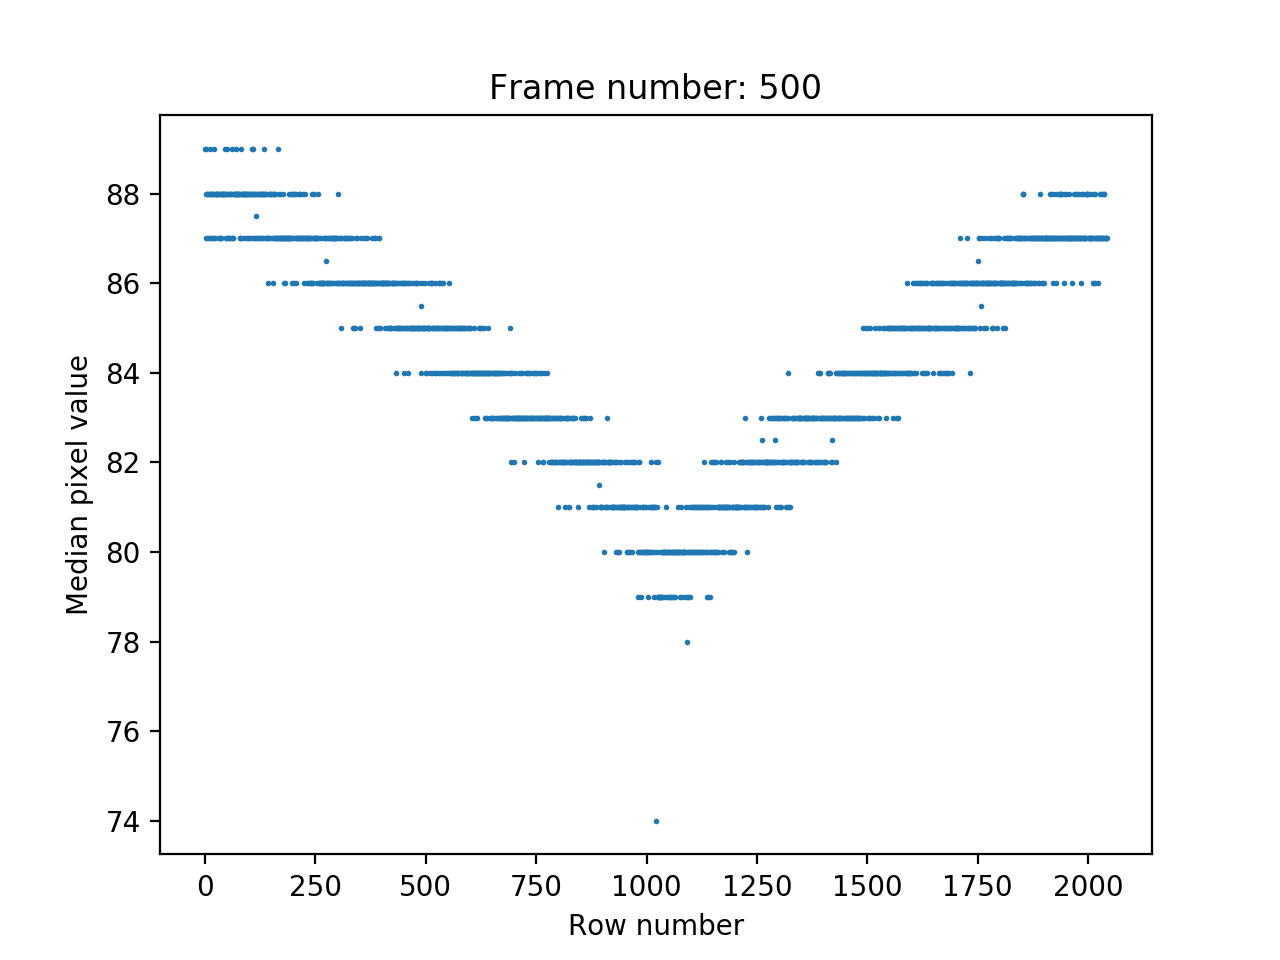

In [13]:
background = np.median(images[:,:,index],axis=(1))
fig, ax = plt.subplots()
plt.scatter(range(background.size),background,s=1)
plt.title('Frame number: ' + str(index+1))
plt.xlabel('Row number')
plt.ylabel('Median pixel value')
plt.show()

<IPython.core.display.Javascript object>


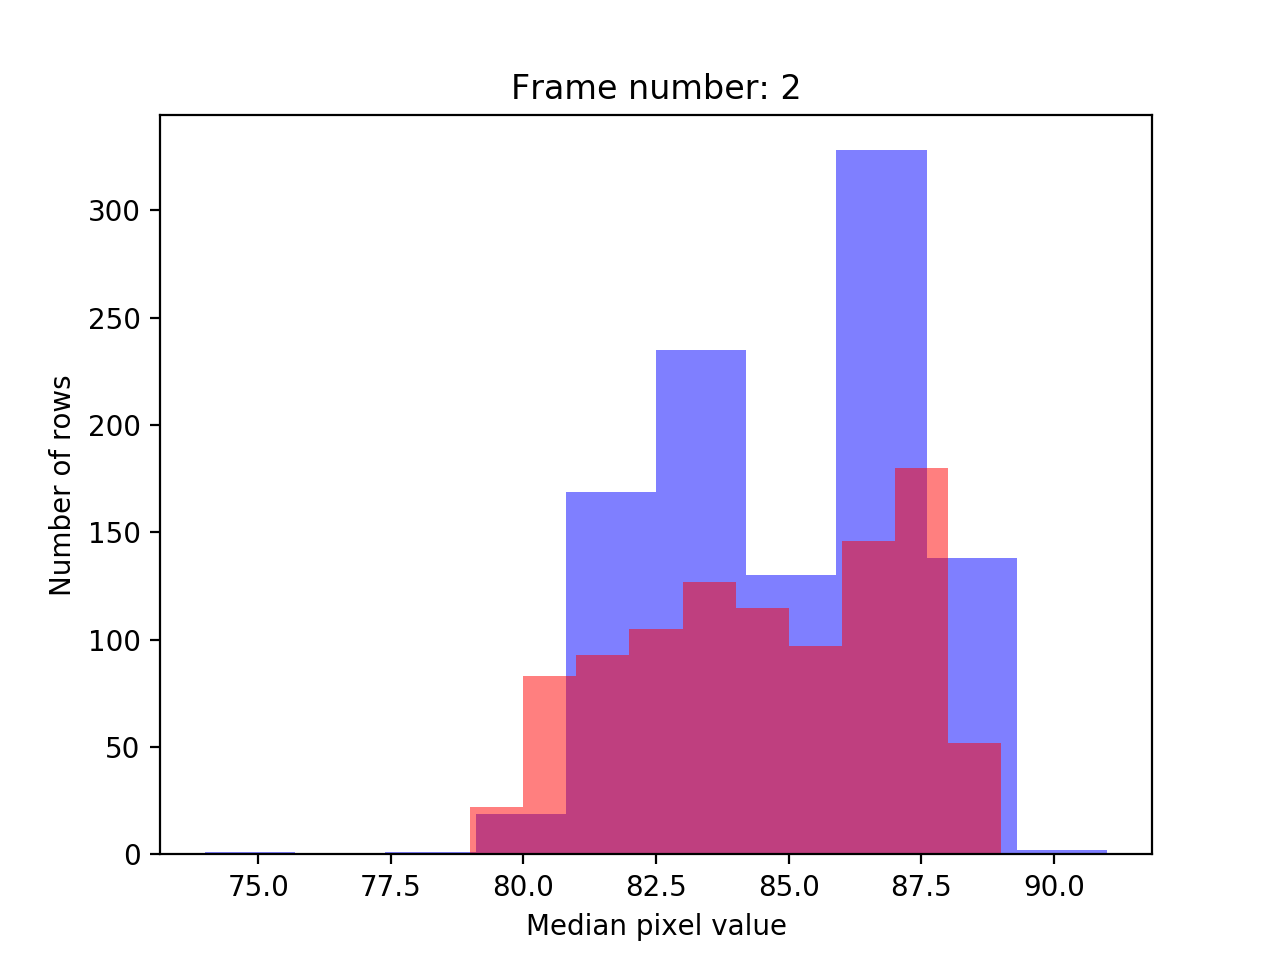

In [32]:
fig, ax = plt.subplots()
plt.hist(background[:1023],color='b',alpha = 0.5)
plt.hist(background[1024:],color='r',alpha = 0.5)
plt.title('Frame number: ' + str(index+1))
plt.xlabel('Median pixel value')
plt.ylabel('Number of rows')


### Compute fixed pattern noise

In [ ]:
np.mean(images)

In [ ]:
avg_noise = np.mean(noise_images,axis=(1,2)).reshape(camera.Y,1) - np.mean(noise_images)
avg_noise_2d = np.tile(avg_noise, (1,camera.X))
plt.imshow(avg_noise_2d,'gray',interpolation='nearest',vmin=-200,vmax=200)


In [ ]:
# Smooth average noise image
sigma = 3
avg_noise_2d_smoothed = scipy.ndimage.filters.gaussian_filter(avg_noise_2d, [sigma, sigma], mode='constant')
plt.imshow(avg_noise_2d_smoothed,'gray',interpolation='nearest',vmin=-200,vmax=200)
#y = sp.ndimage.filters.gaussian_filter(x, sigma, mode='constant')

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (20,20))

ax1.imshow(images[:,:,index]-avg_noise,'gray',interpolation='nearest',vmin=200,vmax=2000)
ax2.imshow(images[:,:,index],'gray',interpolation='nearest',vmin=200,vmax=2000)

In [ ]:
plt.plot(range(avg_noise.size),avg_noise)

In [ ]:
im = Image.fromarray(images[:,:,index])
im.save('C:\\Users\\AERB\\Desktop\\Kevin\\img.tiff')


#scipy.misc.imsave('C:\Users\AERB\Desktop\Kevin\img.tiff', images[:,:,index])

In [ ]:
cam_settings = pco_cam.sdk.get_camera_description()

# Write JSON
with open('./camera_description_pco_testing.json', 'w') as write_file:
    json.dump(cam_settings, write_file, indent=4)


In [ ]:
print(pco_cam.sdk.get_camera_setup())
#print(pco_cam.sdk.get_camera_synch_mode())